# Model Development and Evaluation using Mean Daily Values
The following notebook will explore how a multiple linear regression can explore the daily mean concentration of four pollutants with the mean weather data and the upstream and oil and gas activity data.

## Definition of Models
A set of features for each pollutant were selected based on the correlations shown in the heat map and the scatter plots.

**Y1: SO2**
X1: Temperature, X2: Wind speed, X3: Humidity, X4: Gas produced

**Y2: TRS**
X1: Wind speed, X2: Wind direction, X3: Depth drilled, X4: Gas produced

**Y3: NO2**
X1: Temperature, X2: Wind direction, X3: Wind speed, X4: Humidity, X5: Depth drilled, X6: Gas produced

**Y4: O3**
X1: Temperature, X2: Wind direction, X3: Wind speed, X4: Humidity, X5: Depth drilled, X6: Gas produced

### Data Splitting, Loss Functions & Cross-Validation

**Data Splitting**
The dataset will be split into a training and a testing dataset. The test dataset will include approximately 1/3 of the dataset to ensure that both the testing and the training sets are representative of the smaller-sized dataset.

**Feature Selection**
The correlation heat maps will be used to select the dependant variables. The features will not be scaled as these are not large datasets, and therefore the time to converge is not a concern.

**Loss Functions**
The sklearn LinearRegression fits a linear model that minimizes the Root Mean Squared Error (RMSE) loss function. This loss function cannot be changed. This loss function has the model learn the outlier data but applies high penalties to incorrect predictions on outlier data points.

**Cross Validation**
The train-validation-test split will not be used. The model is working with a smaller dataset. Therefore, the data will only be split into a training and a testing set. By introducing a validation set, the smaller size of the training, validation, and testing set will be less representative of the sample data.
A Grid Search Cross-Validation will be used. This grid will explore different parameters for the Linear Regression, including the intercept and is the regressors X will be normalized before regression. A 5-fold split will be used in this grid search to cross validate.

**Evaluation & Testing**
The model will be evaluated using the R^2^ score. The R^2^ measures the proportion of variance in the dependant variable that is predictable from the independent variables and is commonly used for linear regression. A higher R^2^ value indicates a better fit. Residual plots will also be used to ensure no transformations are required for the data and a linear model was the best choice (versus a polynomial).

**Other Possible Models for Future Consideration**
Sklearn offers another linear regression: the Huber Regressor that is a linear regression more robust to outliers and the Lasso model that that combines L1 and L2 loss functions.

In [1]:
# Import third party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lm
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import circmean
import os

In [2]:
# Read in daily df
daily_mean = pd.read_csv('daily_mean.csv')
month_mean = pd.read_csv('month_mean.csv')

# Reset DateTimeIndex
month_mean = month_mean.set_index(pd.DatetimeIndex(month_mean['Datetime']))
month_mean.drop('Datetime', axis=1, inplace=True)
daily_mean = daily_mean.set_index(pd.DatetimeIndex(daily_mean['Datetime']))
daily_mean.drop('Datetime', axis=1, inplace=True)

As observed in the EDA section, the model when in hourly or daily aggregations have a high amount of noise. Daily models will be fit using the raw daily values, as well as daily values that have undergone a moving average smoothing.

In [3]:
# Smooth the data using a moving average
# The parameters to be smoothed using the rolling average include the temperature, wind speed, humidity, and the air pollutants
monitor_params = ['TEMP_MEAN_(C)', 'WDIR_VECT_(DEG)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'SO2', 'TRS', 'NOx', 'NO', 'NO2', 'O3']

# Make a copy of the daily mean df
daily_mean_ma = daily_mean.copy()

# Loop through selected parameters for rolling average
for param in monitor_params:
    daily_mean_ma[param] = daily_mean_ma[param].rolling(3, center=True, closed='both').mean()

daily_mean_ma.dropna(inplace=True)

Below is a figure demonstrating the difference between the daily mean and the daily moving average.

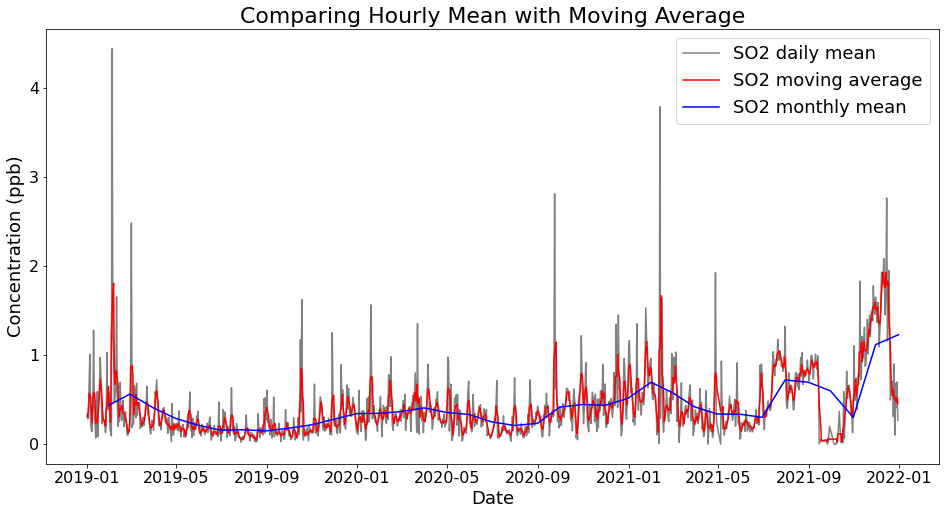

In [8]:
plt.figure(figsize = (16,8))

plt.plot(daily_mean.index, daily_mean['SO2'], 'gray', label = 'SO2 daily mean')
plt.plot(daily_mean_ma.index, daily_mean_ma['SO2'], 'r', label = 'SO2 moving average')
plt.plot(month_mean.index, month_mean['SO2'], 'b', label = 'SO2 monthly mean')

plt.xlabel('Date', fontsize = 18)
plt.xticks(fontsize = 16)
plt.ylabel('Concentration (ppb)', fontsize = 18)
plt.yticks(fontsize = 16)
plt.title('Comparing Hourly Mean with Moving Average', fontsize = 22)
plt.legend(fontsize=18)
plt.show()

Next, the models will be fit using the daily mean and the daily moving average. The r-squared values for each will be compared.

## Model 1: SO2
### Mean Daily

In [37]:
# Split df into x and y
X =  daily_mean.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'gas_prod_vol_m3'], axis=1)
y = daily_mean.filter(['SO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean.shape[0] * 100))

Train 66.91519105312209%
Test 33.084808946877914%


In [38]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.26395820679674087


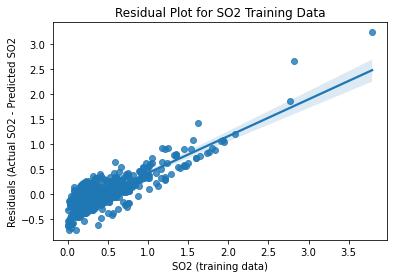

In [39]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['SO2'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual SO2 - Predicted SO2')
plt.title('Residual Plot for SO2 Training Data')
plt.show()

In [40]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.1605577689158153


### Daily Mean Moving Average

In [41]:
# Split df into x and y
X =  daily_mean_ma.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'gas_prod_vol_m3'], axis=1)
y = daily_mean_ma.filter(['SO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean.shape[0] * 100))

Train 66.91519105312209%
Test 32.99161230195713%


In [42]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.3924696192287116


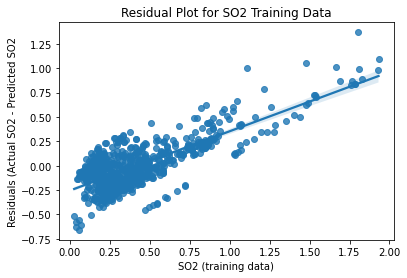

In [43]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['SO2'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual SO2 - Predicted SO2')
plt.title('Residual Plot for SO2 Training Data')
plt.show()

In [44]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.3022220805017378


## Model 2: TRS
### Mean Daily

In [46]:
# Split df into x and y
X =  daily_mean.filter(['WSPD_SCLR_(M/S)', 'WDIR_VECT_(DEG)', 'Depth_per_day', 'gas_prod_vol_m3'], axis=1)
y = daily_mean.filter(['TRS'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean.shape[0] * 100))

Train 66.91519105312209%
Test 33.084808946877914%


In [47]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.30273032970430735


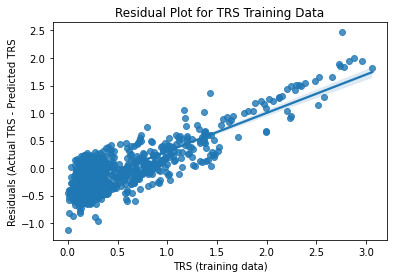

In [48]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['TRS'])
ax.set_xlabel('TRS (training data)')
ax.set_ylabel('Residuals (Actual TRS - Predicted TRS')
plt.title('Residual Plot for TRS Training Data')
plt.show()

In [49]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.27012478754999625


### Daily Mean Moving Average

In [50]:
# Split df into x and y
X =  daily_mean_ma.filter(['WSPD_SCLR_(M/S)', 'WDIR_VECT_(DEG)', 'Depth_per_day', 'gas_prod_vol_m3'], axis=1)
y = daily_mean_ma.filter(['TRS'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean_ma.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean_ma.shape[0] * 100))

Train 66.97761194029852%
Test 33.02238805970149%


In [51]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.34264868641576685


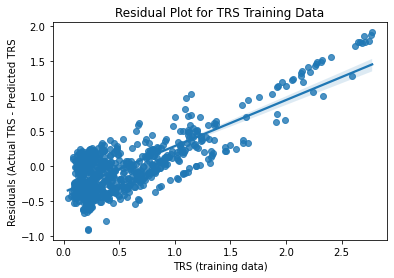

In [52]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['TRS'])
ax.set_xlabel('TRS (training data)')
ax.set_ylabel('Residuals (Actual TRS - Predicted TRS')
plt.title('Residual Plot for TRS Training Data')
plt.show()

In [53]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.3067998679229892


## Model 3: NO2
### Mean Daily

In [20]:
# Split df into x and y
X =  daily_mean.filter(['TEMP_MEAN_(C)', 'WDIR_VECT_(DEG)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'Depth_per_day','gas_prod_vol_m3'], axis=1)
y = daily_mean.filter(['NO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean.shape[0] * 100))

Train 66.91519105312209%
Test 33.084808946877914%


In [21]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.34175170932216714


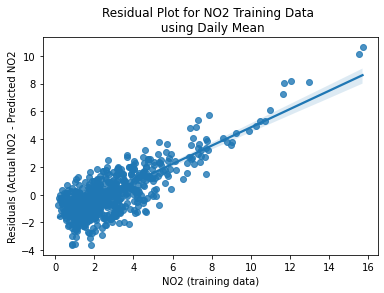

In [23]:
# Plot the residuals
residuals = y_train - y_fitted

ax = sns.regplot(x=y_train, y=residuals['NO2'])
ax.set_xlabel('NO2 (training data)')
ax.set_ylabel('Residuals (Actual NO2 - Predicted NO2')
plt.title('Residual Plot for NO2 Training Data \n using Daily Mean')
plt.show()

In [57]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.3129876805237405


### Daily Mean Moving Average

In [12]:
# Split df into x and y
X =  daily_mean_ma.filter(['TEMP_MEAN_(C)', 'WDIR_VECT_(DEG)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'Depth_per_day','gas_prod_vol_m3'], axis=1)
y = daily_mean_ma.filter(['NO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean_ma.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean_ma.shape[0] * 100))

Train 66.97761194029852%
Test 33.02238805970149%


In [13]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.4287913273841861


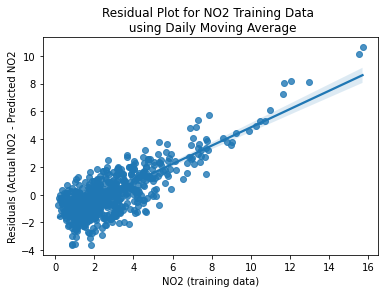

In [24]:
# Plot the residuals
residuals = y_train - y_fitted

ax = sns.regplot(x=y_train, y=residuals['NO2'])
ax.set_xlabel('NO2 (training data)')
ax.set_ylabel('Residuals (Actual NO2 - Predicted NO2')
plt.title('Residual Plot for NO2 Training Data \n using Daily Moving Average')
plt.show()

In [61]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.36063074980691334


## Model 4: O3
### Daily Mean

In [62]:
# Split df into x and y
X =  daily_mean.filter(['TEMP_MEAN_(C)', 'WDIR_VECT_(DEG)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)','gas_prod_vol_m3'], axis=1)
y = daily_mean.filter(['O3'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean.shape[0] * 100))

Train 66.91519105312209%
Test 33.084808946877914%


In [63]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.5679183741344915


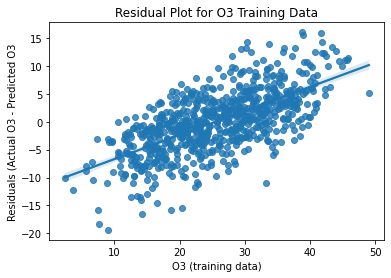

In [64]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['O3'])
ax.set_xlabel('O3 (training data)')
ax.set_ylabel('Residuals (Actual O3 - Predicted O3')
plt.title('Residual Plot for O3 Training Data')
plt.show()

In [65]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.5394383620268419


### Daily Mean Moving Average

In [66]:
# Split df into x and y
X =  daily_mean_ma.filter(['TEMP_MEAN_(C)', 'WDIR_VECT_(DEG)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)','gas_prod_vol_m3'], axis=1)
y = daily_mean_ma.filter(['O3'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / daily_mean_ma.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / daily_mean_ma.shape[0] * 100))

Train 66.97761194029852%
Test 33.02238805970149%


In [67]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression()

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.6512006154165239


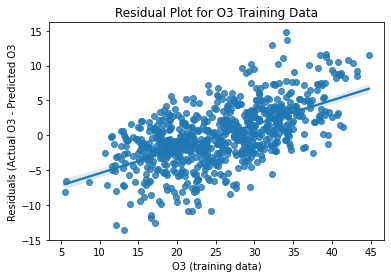

In [68]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['O3'])
ax.set_xlabel('O3 (training data)')
ax.set_ylabel('Residuals (Actual O3 - Predicted O3')
plt.title('Residual Plot for O3 Training Data')
plt.show()

In [69]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.6147411144200924
